In [7]:
import tensorflow as tf
import tensorflow_gan as tfgan
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
import pandas as pd
import glob
import os
import PIL
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import seaborn as sb
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot
sb.set()

In [8]:
import os 
import earthpy as et 

In [9]:
## Code needed to set a new working directory

#my_path = os.path.join(et.io.HOME, 'recommender_system')
#os.mkdir(my_path)

## Set Working Directory
os.chdir(os.path.join(et.io.HOME, 'recommender_system'))

In [10]:
# Check if it worked
os.getcwd()

'/Users/chriskamerin/recommender_system'

In [11]:
df =pd.read_csv('data_in_use/headphones2hp.csv')

In [12]:
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
df['user_id']  = pd.Categorical(df.user_id).codes
df['headphone_name']  = pd.Categorical(df.headphone_name).codes

In [16]:
#Set columns we want to normalize

cols_to_norm = ['sound_quality_importance', 'positional_importance', 'loud_importance',
       'mic_importance', 'wireless_importance','noise_canceling_importance', 'in_ear_importance',
       'on_ear_importance', 'over_ear_importance', 'no_pref_oninover', 'recording_quality', 'noise_handling','user_rating',
       'Impedance', 'sensitivity(dbv)', 'accuracy',
       'weighted_harmonic_distortion', 'soundstage', 'imaging',
       'noise_isolation', 'wireless']
imp_col = ['sound_quality_importance', 'positional_importance', 'loud_importance',
       'mic_importance', 'wireless_importance', 
       'price_sensitivity']
#price_col = ['max_price','price']
hp_feat_col = ['recording_quality', 'noise_handling', 'accuracy',
       'weighted_harmonic_distortion', 'soundstage', 'imaging',
       'noise_isolation', 'wireless']
remaining_col = ['Impedance', 'sensitivity(dbv)']



In [22]:
xdf =df[['game_use', 'rec_use', 'studio_use', 'exercise_use',
       'office_use', 'podcast_use', 'travel_use', 'other_use',
       'sound_quality_importance', 'positional_importance', 'loud_importance',
       'mic_importance', 'wireless_importance', 'in_ear_importance',
       'on_ear_importance', 'over_ear_importance', 'no_pref_oninover']]
ydf =df[[ 'attached_mic', 'recording_quality',
       'noise_handling', 'Impedance', 'sensitivity(dbv)', 'accuracy',
       'weighted_harmonic_distortion', 'soundstage', 'imaging',
       'noise_isolation', 'wireless', 'over_ear_style', 'on_ear_style',
       'in_ear_style', 'open_back', 'close_back', 'semiclosed_back']]
#xtest=df1[['game_use', 'rec_use', 'studio_use', 'exercise_use',
#       'office_use', 'podcast_use', 'travel_use', 'other_use',
#       'sound_quality_importance', 'positional_importance', 'loud_importance',
#       'mic_importance', 'wireless_importance', 'in_ear_importance',
#       'on_ear_importance', 'over_ear_importance', 'no_pref_oninover']][12:]
#ytest=df1[[ 'attached_mic', 'recording_quality',
#       'noise_handling', 'Impedance', 'sensitivity(dbv)', 'accuracy',
#       'weighted_harmonic_distortion', 'soundstage', 'imaging',
#       'noise_isolation', 'wireless', 'over_ear_style', 'on_ear_style',
#       'in_ear_style', 'open_back', 'close_back', 'semiclosed_back']][12:]

In [23]:
#normalize columns in df

df=df.fillna(0)
df[imp_col] = df[imp_col].apply(lambda x: (x - 0) / (10 - 0))
#df[price_col] = df[price_col].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df[hp_feat_col] = df[hp_feat_col].apply(lambda x: (x - x.min()) / (x.max() - x.min()))   
df[remaining_col] = df[remaining_col].apply(lambda x: (x - x.min()) / (x.max() - x.min()))       
#df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [41]:
# define the standalone discriminator model
def define_discriminator(n_inputs=34):
	model = Sequential()
	model.add(Dense(256, kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dense(34, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=34):
	model = Sequential()
	model.add(Dense(256, kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dense(n_outputs, activation='linear'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	# x_real, y_real = generate_real_samples(n)
	x_real, y_real = dfx, dfy
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	#pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	#pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	#pyplot.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100, n_batch=32, n_eval=10):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		# x_real, y_real = generate_real_samples(half_batch)
		x_real, y_real = xdf, ydf
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
 
# size of the latent space
latent_dim = 30
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

ValueError: in user code:

    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/chriskamerin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_17 is incompatible with the layer: expected axis -1 of input shape to have value 34 but received input with shape [16, 17]


In [42]:
def define_generator(latent_dim, n_outputs=34):
	model = Sequential()
	model.add(Dense(256, kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dense(n_outputs, activation='linear'))
	return model
# size of the latent space
latent_dim = 50
# create the generator
generator = define_generator(latent_dim)


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               13056     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 34)                8738      
Total params: 21,794
Trainable params: 21,794
Non-trainable params: 0
_________________________________________________________________


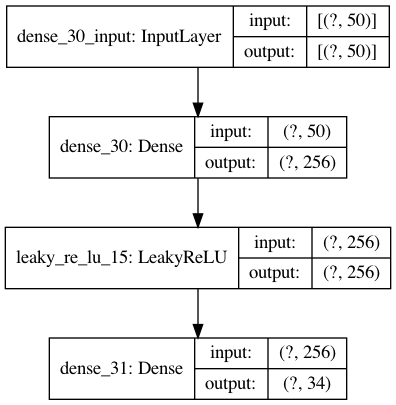

In [43]:
# summarize the model
generator.summary()
# plot the model
plot_model(generator, show_shapes=True, show_layer_names=True)

In [47]:
def define_discriminator(n_inputs=34):
	model = Sequential()
	model.add(Dense(256, kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dense(34, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [48]:
discriminator = define_discriminator()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 256)               8960      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 34)                8738      
Total params: 17,698
Trainable params: 17,698
Non-trainable params: 0
_________________________________________________________________


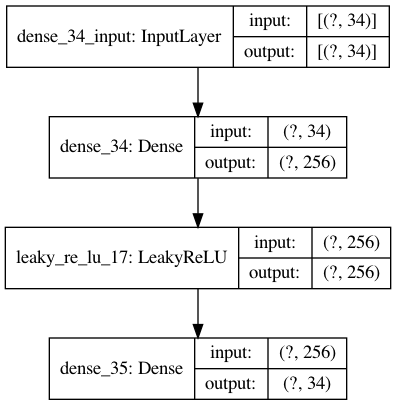

In [49]:
discriminator.summary()
# plot the model
plot_model(discriminator, show_shapes=True, show_layer_names=True)